# Analysis

In [1]:
using AlgebraOfGraphics,
    CairoMakie
using DataFrames,
    DataFramesMeta,
    CategoricalArrays
using Arrow
using Statistics
import JSON

In [2]:
dim = 3
beta = 0.25
theta = 60
dir = "01_oblique_linear_alfven/dim_$(dim)_beta_$(beta)_theta_$(theta)"
try
    cd(dir)
    println("Changed to directory: $(dir)")
catch
end

# load simulation metadata (json)
meta = JSON.parsefile("sim_parameters.json")

Changed to directory: 01_oblique_linear_alfven/dim_3_beta_0.25_theta_60


Dict{String, Any} with 45 entries:
  "diag_field"  => true
  "w_pi"        => 28207.3
  "Lz_norm"     => 256
  "dt"          => 0.00223274
  "Lx_norm"     => 8.0
  "m_ion_norm"  => 400
  "nz"          => 128
  "Te"          => 61.9306
  "wave_number" => 4
  "dz_norm"     => 2.0
  "vA_over_c"   => 0.00155689
  "Lz"          => 2.72082e6
  "nppc"        => 64
  "dz"          => 21256.4
  "k"           => 9.23721e-6
  "grid_kwargs" => Dict{String, Any}("warpx_blocking_factor_y"=>4, "warpx_block…
  "m_ion"       => 3.64375e-28
  "diag_format" => "plotfile"
  "dim"         => 3
  ⋮             => ⋮

In [3]:
meta["t_ci"]
meta["d_i"]

10628.186523164071

In [9]:
ext = "arrow"

if meta["diag_format"] == "openpmd"
    field_diag_dir = "diags/diag1"
else
    field_diag_dir = "diags"
end

"diags"

In [10]:
function normalize_df!(df)
    df.time_norm = df.time ./ meta["t_ci"]
    return df
end

normalize_df! (generic function with 1 method)

In [11]:
files = filter(contains(r".*\.arrow"), readdir(field_diag_dir, join=true))
dfs = vcat(files .|> Arrow.Table .|> DataFrame)
df = reduce(vcat,dfs) |> normalize_df!

124928×14 DataFrame
    Row │ Bx          By           Bz          Ex            Ey            Ez  ⋯
        │ Float64?    Float64?     Float64?    Float64?      Float64?      Flo ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 8.66025e-8   4.97592e-8  5.0e-8       0.0           0.0           0. ⋯
      2 │ 8.66025e-8   4.7847e-8   5.0e-8       0.0           0.0           0.
      3 │ 8.66025e-8   4.40961e-8  5.0e-8       0.0           0.0           0.
      4 │ 8.66025e-8   3.86505e-8  5.0e-8       0.0           0.0           0.
      5 │ 8.66025e-8   3.17197e-8  5.0e-8       0.0           0.0           0. ⋯
      6 │ 8.66025e-8   2.35698e-8  5.0e-8       0.0           0.0           0.
      7 │ 8.66025e-8   1.45142e-8  5.0e-8       0.0           0.0           0.
      8 │ 8.66025e-8   4.90086e-9  5.0e-8       0.0           0.0           0.
   ⋮    │     ⋮            ⋮           ⋮            ⋮             ⋮            ⋱
 124922 │ 9.01589e-8  -1.77347e-8  3.19214e-8   0.000780628   0.00163237   -0. ⋯
 124923 │ 8.41314e-8   1.95814e-9  3.92438e-8   0.000193545   0.00193337   -1.
 124924 │ 8.02538e-8   1.78836e-8  3.3571e-8    0.00183468    0.00378106   -0.
 124925 │ 9.51025e-8   1.6514e-8   4.70606e-8   0.00245359    0.00105008   -0.
 124926 │ 1.001e-7     2.39985e-8  7.36901e-8  -0.00222302    0.000323648   0. ⋯
 124927 │ 7.44065e-8   1.48455e-8  7.90814e-8  -0.00284822    0.000165463   0.
 124928 │ 8.84661e-8  -3.34603e-8  8.86284e-8   0.000754499  -0.000650734  -0.
                                               9 columns and 124913 rows omitted

In [12]:
B_fields = names(df, r"B")
E_field = names(df, r"E")
j_field = names(df, r"j")

variables = [B_fields; E_field; j_field]

9-element Vector{String}:
 "Bx"
 "By"
 "Bz"
 "Ex"
 "Ey"
 "Ez"
 "jx"
 "jy"
 "jz"

In [19]:
# calculate the mean of the data by averaging over "y" and "z"
ids = [:z, :time_norm]

function plot_fields(df, fields; ids=ids)
    temp_df = @chain df begin
        groupby(ids)
        combine(fields .=> mean, renamecols=false)
        stack(fields, ids)
    end

    plt = data(temp_df) * mapping(ids..., :value, row = :variable) * visual(Heatmap)
    draw(plt)
end

function plot_fields_time(df, fields; ids=ids)
    temp_df = @chain df begin
        groupby(ids)
        combine(fields .=> mean, renamecols=false)
        stack(fields, ids)
    end
    
    temp_df.time_norm = CategoricalArray(temp_df.time_norm .|> floor)

    height = 100 * length(unique(temp_df.time_norm))
    fig_options = (size = (1200, height),)

    plt = data(temp_df) * mapping(:z, :value, col = :variable, row= :time_norm)
    draw(plt; figure = fig_options)
end

plot_fields_time (generic function with 1 method)

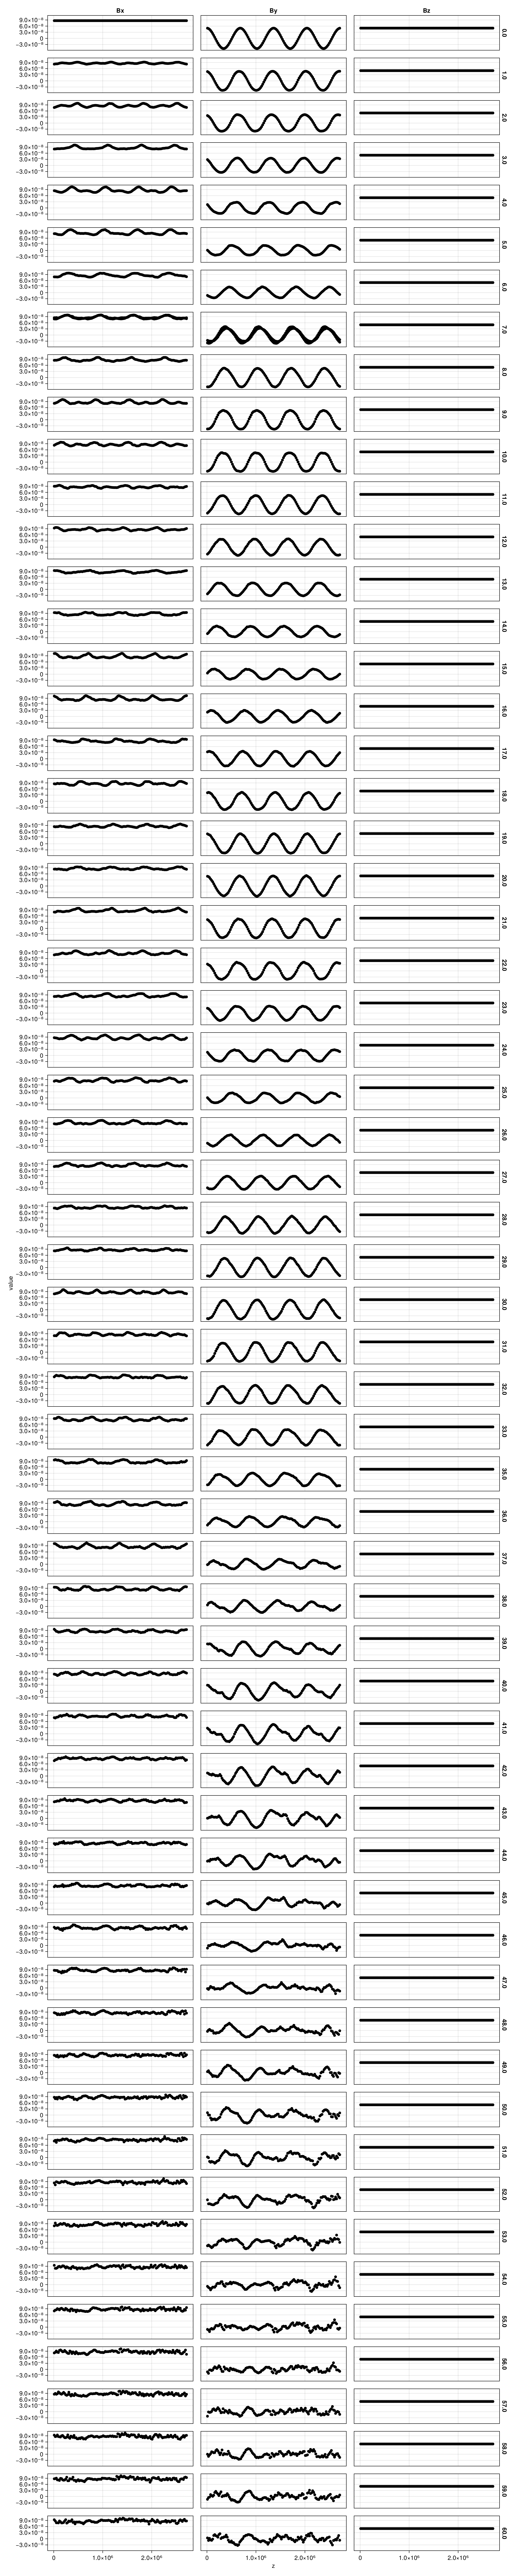

In [20]:
plot_fields_time(df, B_fields)

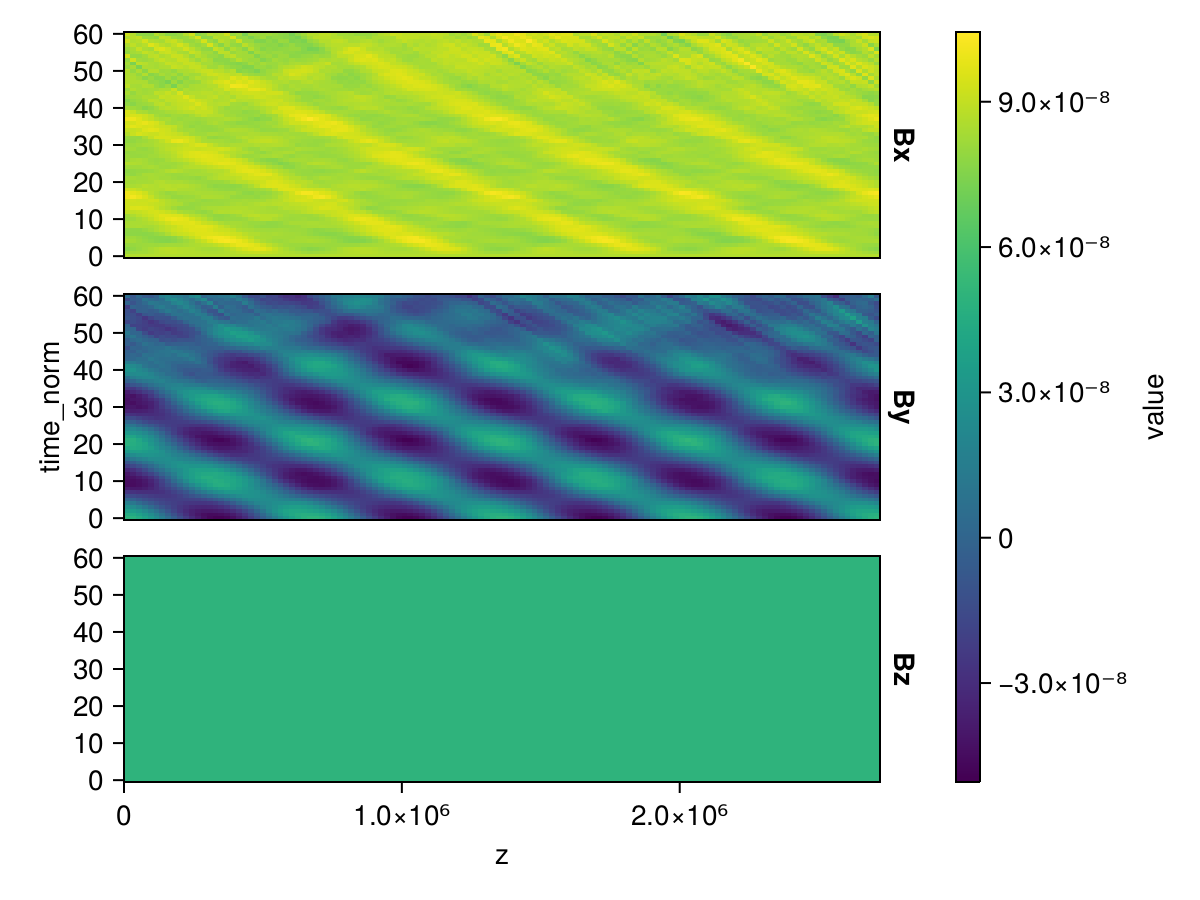

In [21]:
plot_fields(df, B_fields)

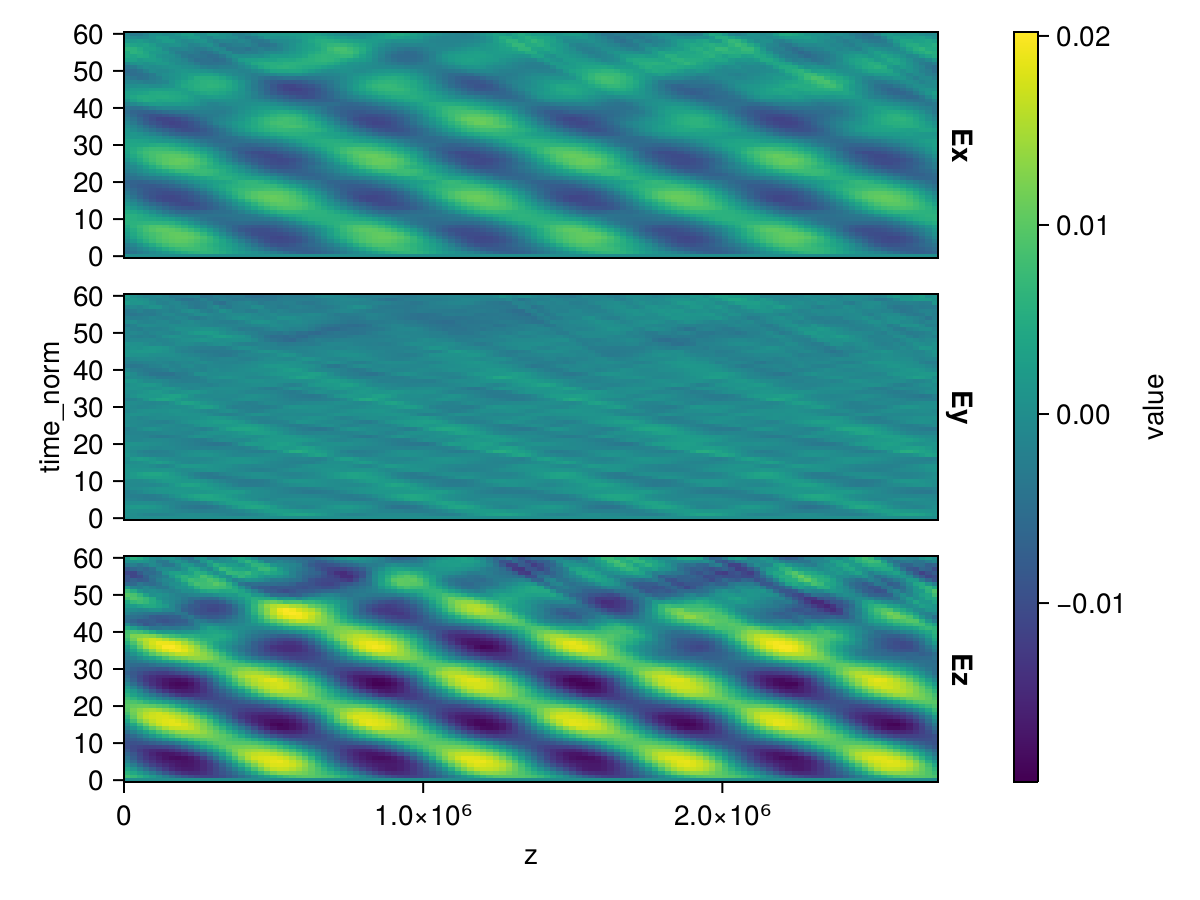

In [22]:
plot_fields(df, E_field)

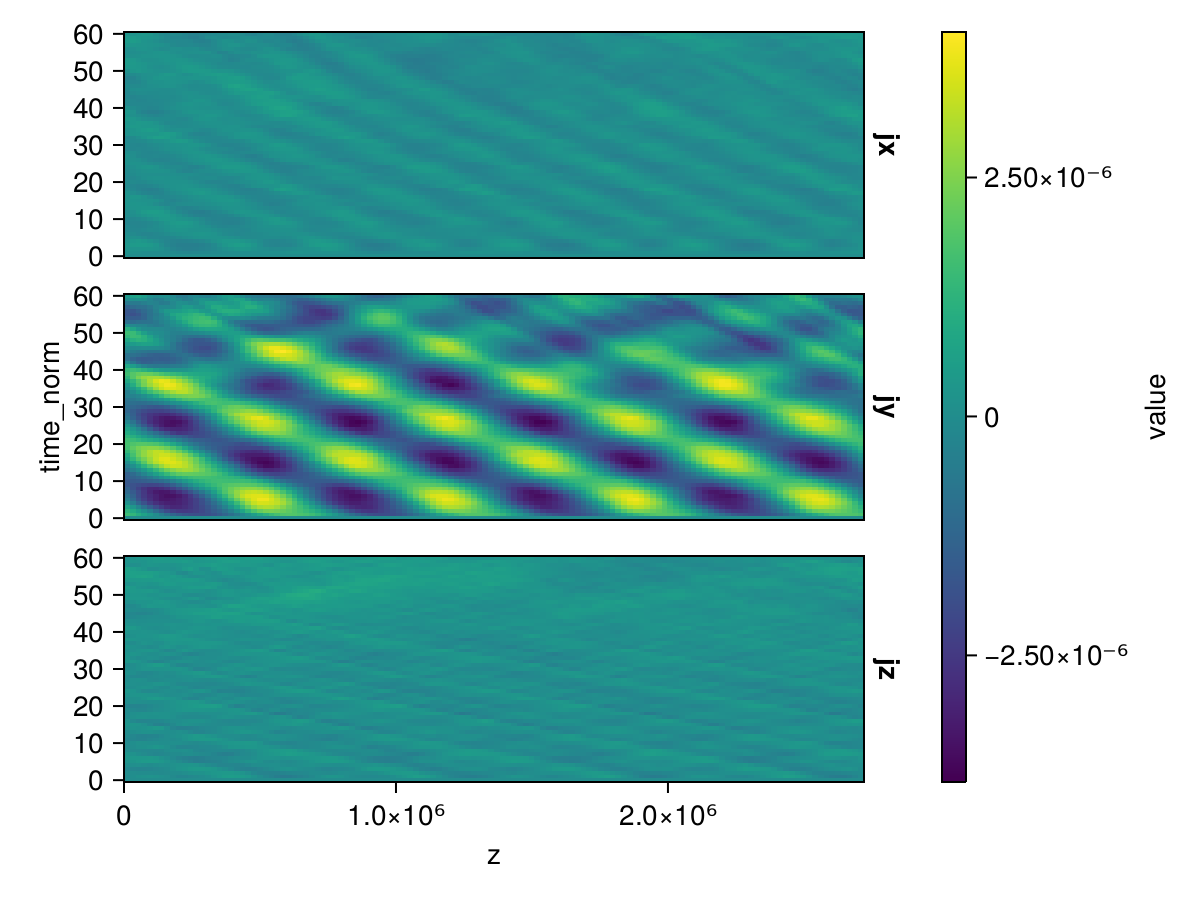

In [23]:
plot_fields(df, j_field)

## Fluid fields

In [ ]:
file = "particle.arrow"
path = joinpath(dir, file)
df = path |> Arrow.Table |> DataFrame

In [ ]:
df.z_norm = df.particle_position_z / meta["d_i"]
df.py_norm = df.particle_momentum_y / 1e-25

In [ ]:
plt = data(df) * mapping(:particle_position_z, :time,:particle_momentum_y) * visual(Heatmap)
draw(plt)

### Non-binned particle data

In [ ]:
df.time_norm = CategoricalArray(df.time ./ meta["t_ci"])

In [ ]:
z_norm_edge = 0:1:240
py_norm_edge = -1e3:10:1e3

In [ ]:
datalimits_f = x -> quantile(x, [0.05, 0.95])

In [ ]:
fig_options = (size = (1200, 1000),)

plt = data(df) * mapping(:z_norm, :py_norm, layout=:time_norm) * histogram(datalimits=datalimits_f)
p = draw(plt; figure = fig_options)

## Parameters

In [ ]:
using Pkg
Pkg.add("Symbolics")

In [ ]:
using Symbolics

In [ ]:
@variables t x y μ_0 B ρ c n q m ϵ_0

Alfven_speed = B / sqrt(μ_0 * ρ)

# plasma frequency
ω_p = sqrt(n * q / (m * ϵ_0))
# inertial_length
d_i = c / ω_p

# gryofrequency
ω_c = q * B / m


simplify(ω_c / ω_p)

In [ ]:
ω_c / ω_p